
# Vanilla PnP for computed tomography (CT).

This example shows how to use a standart PnP algorithm with DnCNN denoiser for computed tomography.


In [8]:
import deepinv as dinv
from pathlib import Path
import torch
from deepinv.models import DnCNN, DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves

## Setup paths for data loading and results.




In [9]:
BASE_DIR = Path(".")
RESULTS_DIR = BASE_DIR / "results"

## Load image and parameters



In [10]:
# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
# Set up the variable to fetch dataset and operators.
method = "PnP"
img_size = 32
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
operation = "tomography"

## Set the forward operator
We use the :class:`deepinv.physics.Tomography`
class from the physics module to generate a CT measurements.



In [11]:
noise_level_img = 0.03  # Gaussian Noise standard deviation for the degradation
angles = 100
n_channels = 1  # 3 for color images, 1 for gray-scale images
physics = dinv.physics.Tomography(
    img_width=img_size,
    angles=angles,
    circle=False,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img),
)

PI = 4 * torch.ones(1).atan()
SCALING = PI / (2 * angles)  # approximate operator norm of A^T A

# Use parallel dataloader if using a GPU to fasten training,
# otherwise, as all computes are on CPU, use synchronous data loading.
num_workers = 4 if torch.cuda.is_available() else 0

## Set up the PnP algorithm to solve the inverse problem.
We use the Proximal Gradient Descent optimization algorithm.
The algorithm alternates between a denoising step and a gradient descent step.
The denoising step is performed by a DNCNN pretrained denoiser :class:`deepinv.models.DnCNN`.

Set up the PnP algorithm parameters : the ``stepsize``, ``g_param`` the noise level of the denoiser.
Attention: The choice of the stepsize is crucial as it also defines the amount of regularization.  Indeed, the regularization parameter ``lambda`` is implicitly defined by the stepsize.
Both the stepsize and the noise level of the denoiser control the regularization power and should be tuned to the specific problem.
The following parameters have been chosen manually.



In [12]:
params_algo = {"stepsize": 0.01 * SCALING, "g_param": noise_level_img}
max_iter = 100
early_stop = True

# Select the data fidelity term
data_fidelity = L2()

# Specify the denoising prior
denoiser = DRUNet(
    in_channels=n_channels,
    out_channels=n_channels,
    pretrained="download",  # automatically downloads the pretrained weights, set to a path to use custom weights.
    device=device,
)
prior = PnP(denoiser=denoiser)

# Logging parameters
verbose = True
plot_metrics = True  # compute performance and convergence metrics along the algorithm, curved saved in RESULTS_DIR

# instantiate the algorithm class to solve the IP problem.
# intialize with the rescaled adjoint such that the initialization lives already at the correct scale
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=lambda y, physics: {
        "est": (physics.A_adjoint(y) * SCALING, physics.A_adjoint(y) * SCALING)
    },
)

# Set the model to evaluation mode. We do not require training here.
model.eval()

BaseOptim(
  (fixed_point): FixedPoint(
    (iterator): PGDIteration(
      (f_step): fStepPGD()
      (g_step): gStepPGD()
    )
  )
)

## Evaluate the model on the problem and plot the results.

The model returns the output and the metrics computed along the iterations.
For computing PSNR, the ground truth image ``x_gt`` must be provided.



Linear reconstruction PSNR: 17.39 dB
PnP reconstruction PSNR: 16.45 dB


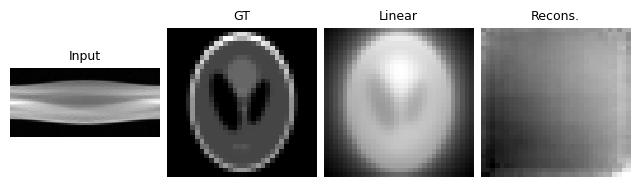

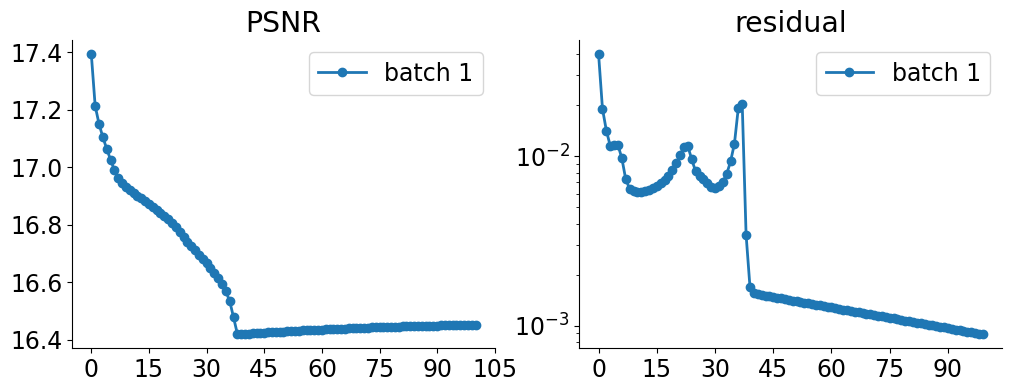

In [13]:
y = physics(x)
x_lin = (
    physics.A_adjoint(y) * SCALING
)  # rescaled linear reconstruction with the adjoint operator

# run the model on the problem.
x_model, metrics = model(
    y, physics, x_gt=x, compute_metrics=True
)  # reconstruction with PnP algorithm

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(f"PnP reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_model):.2f} dB")

# plot images. Images are saved in RESULTS_DIR.
imgs = [y, x, x_lin, x_model]
plot(
    imgs,
    titles=["Input", "GT", "Linear", "Recons."],
    save_dir=RESULTS_DIR / "images",
    show=True,
)

# plot convergence curves. Metrics are saved in RESULTS_DIR.
if plot_metrics:
    plot_curves(metrics, save_dir=RESULTS_DIR / "curves", show=True)